# Mouse Perturbation Analysis

**Date** : 2022-05-04<br>
**Author** : Alma Andersson<br>
**Description** : <br>
This notebook outlines the analysis related to the Mouse Perturbed data.

Load necessary packages

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc

import os.path as osp
import os
from PIL import Image

import anndata as ad
import pandas as pd
import sys

import eggplant as eg



Set plotting parameters

In [4]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "None"
rcParams["axes.facecolor"] = "None"

## Load and process Reference Information

Define paths to data and reference images

In [14]:
DATA_DIR = "/data/alma.andersson/eggplant/data/intermediate/mouse-perturbed/gex/iter-001/"
REF_IMG_PTH = "/data/alma.andersson/eggplant/data/intermediate/mouse-perturbed/reference/mouse-perturbed-iter-001.png"
REF_LMK_PTH = "/data/alma.andersson/eggplant/data/intermediate/mouse-perturbed/reference/mouse-perturbed_landmarks.tsv"

Load reference image

In [6]:
ref_img = Image.open(REF_IMG_PTH)
ref_lmk = pd.read_csv(REF_LMK_PTH,sep="\t",header = 0,index_col =0)

Inspect the reference image to make sure we loaded the correct image. Also plot the landmark coordinates to ensure that these match the reference.

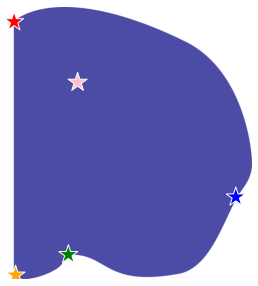

In [7]:
plt.figure(figsize = (5,5))
lmk_cmap = eg.constants.LANDMARK_CMAP
cmap = eg.pl.ColorMapper(lmk_cmap)

plt.imshow(ref_img,alpha = 0.7)
plt.scatter(ref_lmk.values[:,0],
            ref_lmk.values[:,1],
            marker = "*",
            edgecolor = "white",
            c = cmap(ref_lmk),
            s = 400,
           )
plt.axis("off")
plt.show()

Everything seems fine with the reference and landmark coordinates. We therefore proceed to convert the image to a grid with associated meta data (which region each grid point belongs to). The number of points in the grid will be close to `n_approx_points`, the more points, the higher the resolution. The argument `n_regions`specifies how many regions we have defined, by different colors, in our reference.

In [8]:
grid_crd,mta = eg.pp.reference_to_grid(ref_img,
                                    n_approx_points=5000,
                                    n_regions=1,
                                   )

We also plot the newly created grid to make sure it looks as we'd expect it to. We can again overlay the landmarks.

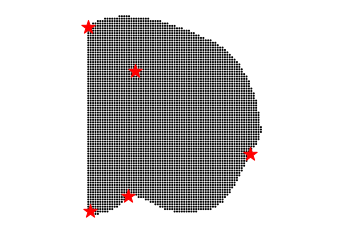

In [9]:
plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            c= mta,
            cmap = plt.cm.binary_r,
            s = 1,
           )

plt.scatter(ref_lmk.values[:,0],
            ref_lmk.values[:,1],
            marker = "*",
            c = "red",
            s = 200,
           )

plt.gca().invert_yaxis()
plt.axis("equal")
plt.axis("off")
plt.show()

From the grid and landmarks we may now create a `Reference` object, which will be used in the transfer process.

In [10]:
ref = eg.m.Reference(grid_crd,
                     landmarks = ref_lmk.values,
                     meta = dict(region = mta),
                    )

## Load and process Expression Data

First, we load the anndata files from the designated data directory `DATA_DIR`

In [24]:
adatas = {p.split(".")[0]:ad.read_h5ad(osp.join(DATA_DIR,p)) for p in os.listdir(DATA_DIR)}

/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [25]:
geo_to_name = {"GSM5519054":"control","GSM5519059":"heme","GSM5519060":"sham"}
adatas = {geo_to_name[key]:val for key,val in adatas.items()}

Next, we execute some standard pre-processing steps such as filter, normalize, log-transform, and scaling. However, we also match the scales between the observed data and the reference (`match_scales`), after which we compute the distance for every spot to each landmark (`get_landmark_distance`). We supply the aforementioned function with the reference object, to conduct TPS warping and thus account for non-homogenous disruptions in the morphology.

In [26]:
for adata in adatas.values():
    eg.pp.default_normalization(adata,
                                min_cells = 0.0,
                                total_counts = 1e4,
                                exclude_highly_expressed=False)
    
    eg.pp.match_scales(adata,ref)
    eg.pp.get_landmark_distance(adata,
                                reference=ref)    



As is proper, we then inspect our processed data to see that everything looks as expected.

In [168]:
GENES = ["Serpina3n", "Cd63", "Timp1"]

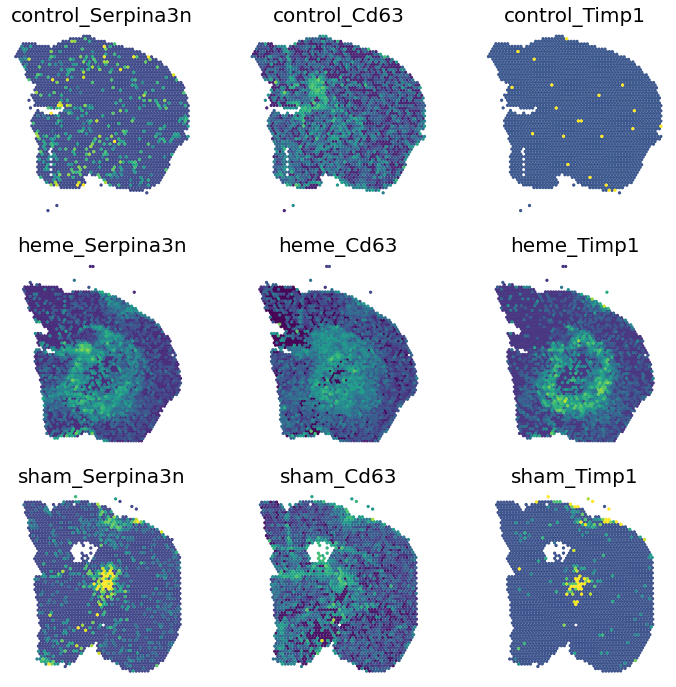

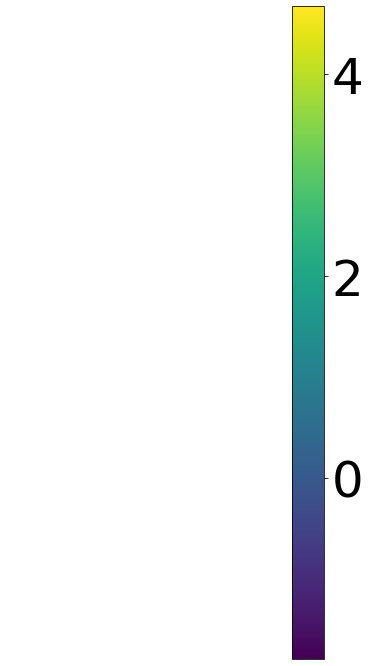

In [169]:
eg.pl.visualize_observed(adatas,
                         features = GENES,
                         n_rows = 2,
                         include_title = True,
                         fontsize = 20,
                         marker_size =5,
                         share_colorscale = True,
                         separate_colorbar = True,
                         side_size = 4,
                         n_cols = len(GENES),
                         show_landmarks = False,
                         quantile_scaling = True,
                         flip_y = True,
                        )

We now transfer our data to the reference using the `transfer_to_reference` function. Here we use the gene _Nrgn_ as our target of interest, but this may be exchanged for any of the other two genes presented in the supplementary (or any gene of the users liking). We use $1000$ epochs and `cuda` acceleration, if possible. We also set `verbose=True` in order to be able to follow the progress.

In [32]:
losses = eg.fun.transfer_to_reference(adatas,
                                      reference=ref,
                                      features = GENES,
                                      n_epochs=1000,
                                      device ="cuda",
                                      verbose=True,
                                     )

[Processing] ::  Model : control | Feature : Serpina3n | Transfer : 1/9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.30it/s]


[Processing] ::  Model : control | Feature : Cd63 | Transfer : 2/9


/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.72it/s]


[Processing] ::  Model : control | Feature : Timp1 | Transfer : 3/9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.51it/s]


[Processing] ::  Model : heme | Feature : Serpina3n | Transfer : 4/9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.65it/s]


[Processing] ::  Model : heme | Feature : Cd63 | Transfer : 5/9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.41it/s]


[Processing] ::  Model : heme | Feature : Timp1 | Transfer : 6/9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.50it/s]


[Processing] ::  Model : sham | Feature : Serpina3n | Transfer : 7/9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.41it/s]


[Processing] ::  Model : sham | Feature : Cd63 | Transfer : 8/9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 32.25it/s]


[Processing] ::  Model : sham | Feature : Timp1 | Transfer : 9/9


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.62it/s]


Having fitted our models, we now inspect their respective losses - to control for any unexpected abberrations - and find that all our curves look as we would expect them to as well as seeming to have converged.

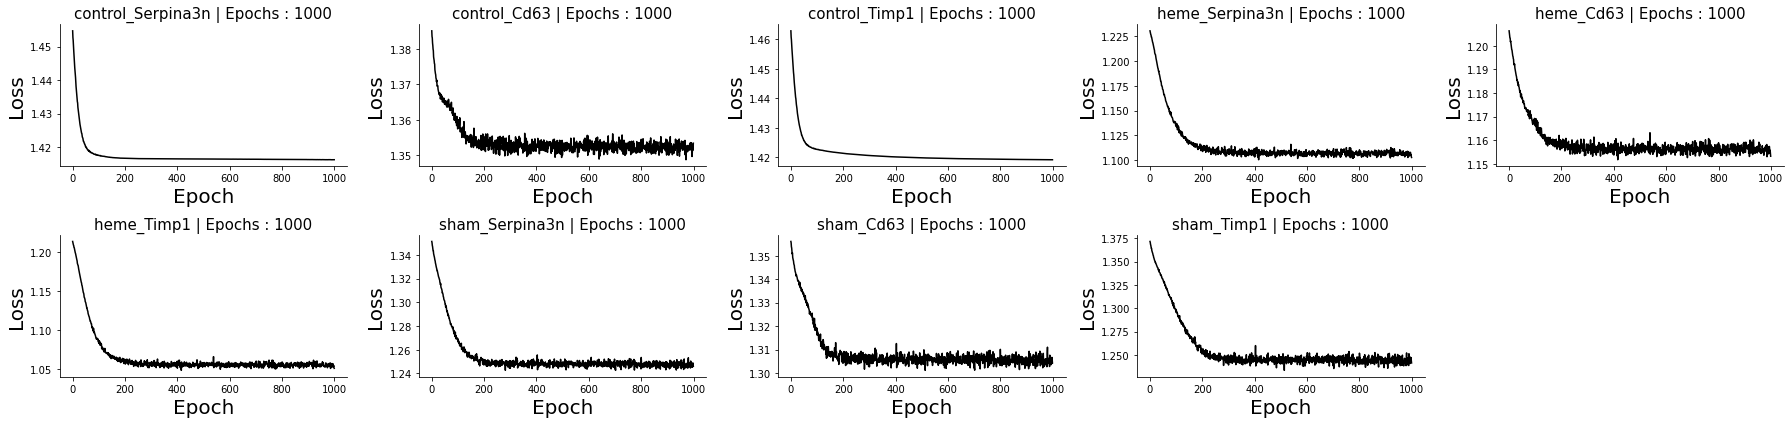

In [33]:
eg.pl.model_diagnostics(losses = losses)

Finally, we visualize our results

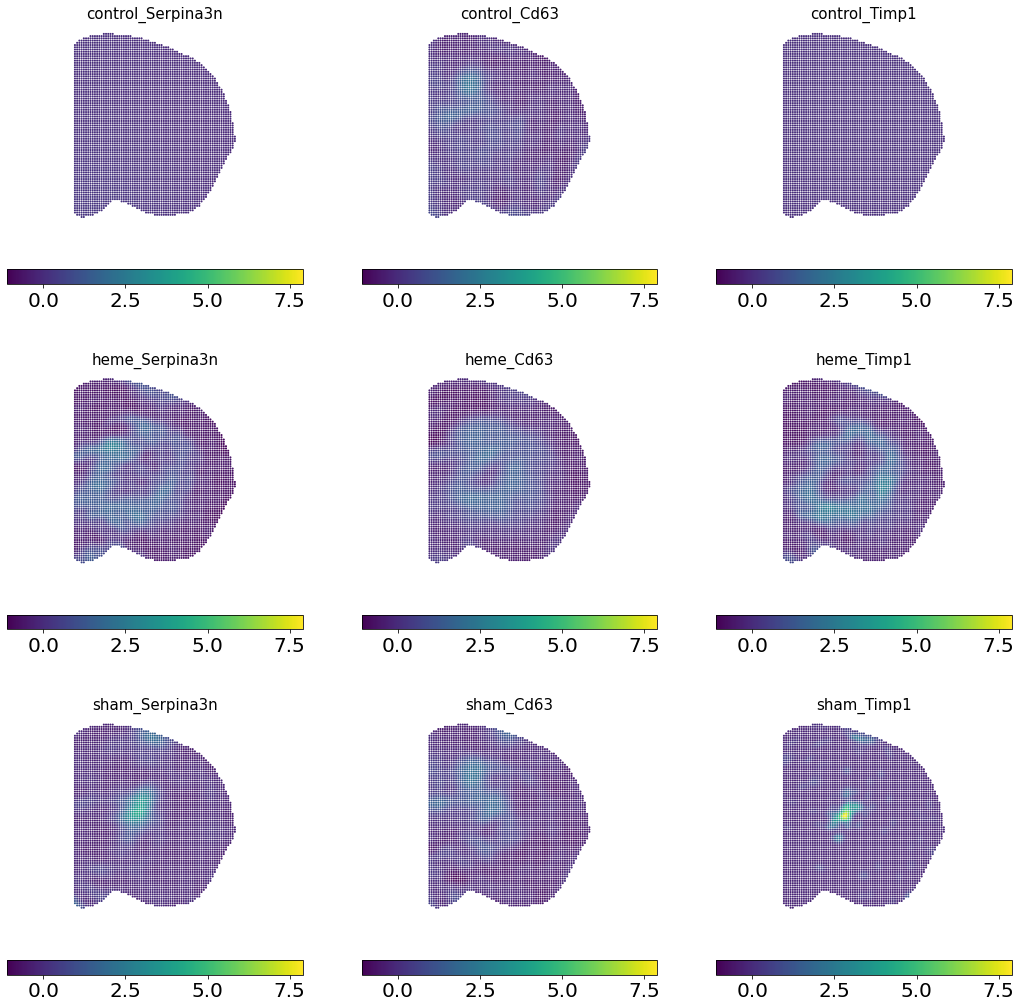

In [34]:
eg.pl.visualize_transfer(ref,
                         n_cols = 3,
                         attributes = GENES,
                         include_title = True,
                         fontsize = 15,
                         marker_size =1,
                         share_colorscale = True,
                         separate_colorbar = False,
                         colorbar_fontsize = 20,
                         side_size = 6,
                         show_landmarks = False,
                         flip_y = True,
                         quantile_scaling = False,
                        )

Next, we conduct a *spatial differential gene expression analysis* (SDEA), with respect to the gene expression. If the interval of $[\mu - 2\sigma, \mu + 2\sigma]$ between any two features overalap at a spatial location, we consider their expression not significantly differentially expressed.

We visualize the results from our SDEA, gray areas indicate locations with no significant differential expression, color regions is the difference between the two compared features' expression

Finally, we generate composite representations and visualize them

In [40]:
res = dict()

for feature in GENES:
    res[feature] = eg.sdea.sdea(ref.adata[:,ref.adata.var.feature.values == feature],
                           group_col="model",
                           n_std=2,)

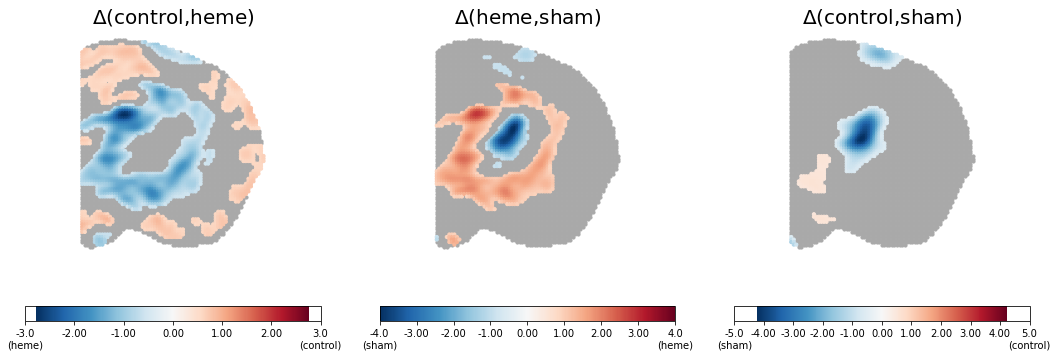

In [43]:
fig,ax = eg.pl.visualize_sdea_results(ref,
                                     res["Serpina3n"],
                                     n_cols = 3,
                                     marker_size = 10,
                                     side_size = 6,
                                     colorbar_orientation ="horizontal",
                                     title_fontsize = 20,
                                     colorbar_fontsize = 10,
                                     no_sig_color = "darkgray",
                                     reorder_axes = [0,2,1],
                                    )

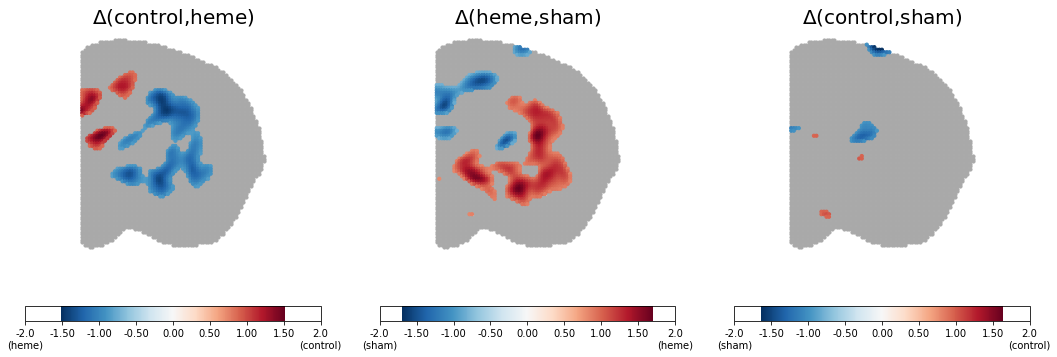

In [44]:
fig,ax = eg.pl.visualize_sdea_results(ref,
                                     res["Cd63"],
                                     n_cols = 3,
                                     marker_size = 10,
                                     side_size = 6,
                                     colorbar_orientation ="horizontal",
                                     title_fontsize = 20,
                                     colorbar_fontsize = 10,
                                     no_sig_color = "darkgray",
                                     reorder_axes = [0,2,1],
                                    )

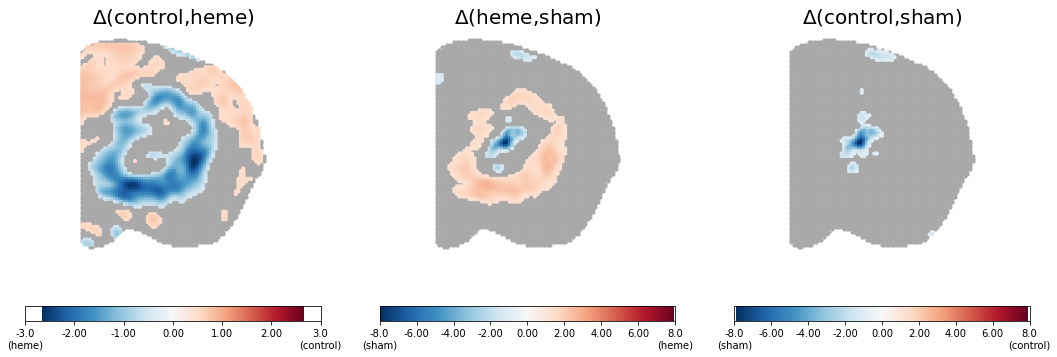

In [45]:
fig,ax = eg.pl.visualize_sdea_results(ref,
                                     res["Timp1"],
                                     n_cols = 3,
                                     marker_size = 10,
                                     side_size = 6,
                                     colorbar_orientation ="horizontal",
                                     title_fontsize = 20,
                                     colorbar_fontsize = 10,
                                     no_sig_color = "darkgray",
                                     reorder_axes = [0,2,1],
                                    )

In [59]:
fa_ref = eg.m.Reference(grid_crd,
                         landmarks = ref_lmk.values,
                         meta = dict(region = mta),
                       )

In [60]:
fa_losses = eg.fun.fa_transfer_to_reference({"heme":adatas["heme"],"sham":adatas["sham"]},
                                            reference=fa_ref,
                                            n_components = 25,
                                            n_epochs=1000,
                                            device ="cuda",
                                            verbose=True,
                                           )

0it [00:00, ?it/s]

[Processing] ::  Model : 0 | Transfer : 0/2


1it [12:58, 778.36s/it]

[Processing] ::  Model : 1 | Transfer : 1/2


/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2it [26:02, 781.02s/it]
/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


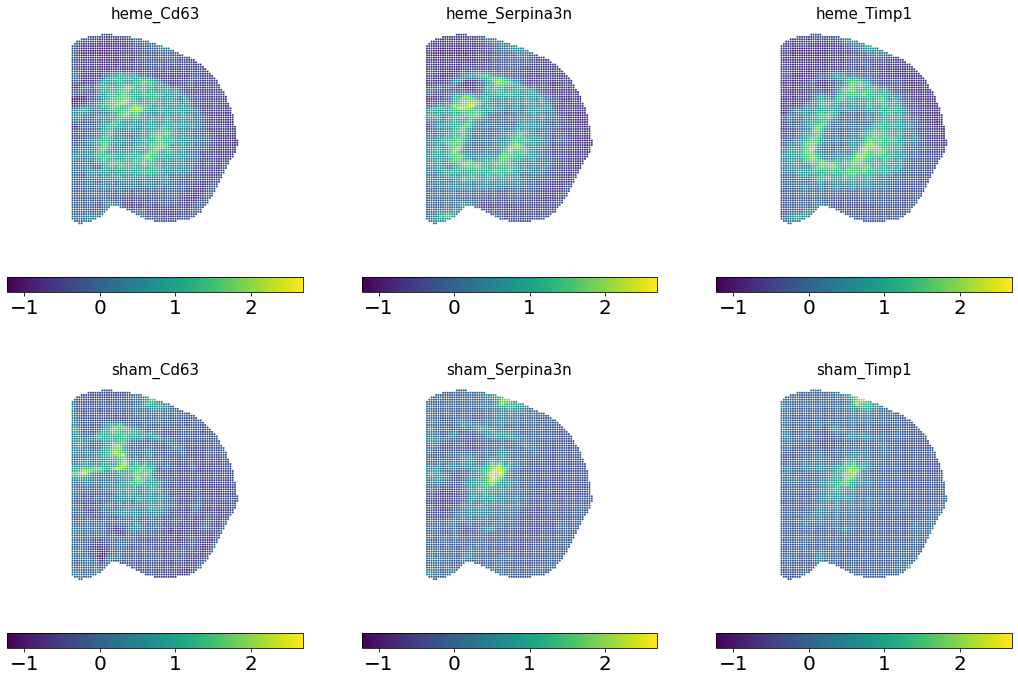

In [66]:
eg.pl.visualize_transfer(fa_ref,
                         n_cols = 3,
                         attributes = GENES,
                         include_title = True,
                         fontsize = 15,
                         marker_size =1,
                         share_colorscale = True,
                         separate_colorbar = False,
                         colorbar_fontsize = 20,
                         side_size = 6,
                         show_landmarks = False,
                         flip_y = True,
                         quantile_scaling = False,
                        )

In [63]:
import numpy as np

In [67]:
def diff_z_score(mu_x,mu_y,var_x,var_y):
    mu_delta = mu_x - mu_y
    divisor = np.sqrt(var_x + var_y)
    return mu_delta / divisor

In [70]:
import pandas as pd
from typing import Optional

In [174]:
uni_labels = np.unique(ref.adata.var["model"])

In [176]:
uni_labels

from itertools import combinations
cc = combinations(uni_labels,2)

In [182]:
def find_sde_features(adata: ad.AnnData,
                      n_features = 100,
                      group_by: str = "model",
                      labels: Optional[str] = None,
                      compare: str = "feature"):
    import itertools
    
    mu = np.asarray(adata.X)
    var = np.asarray(adata.layers["var"])
    features = adata.var[compare].values
    label_values = adata.var[group_by].values
    
    if labels is None:
        uni_labels = np.unique(label_values)
    else:
        uni_labels = labels
    
    combs = itertools.combinations(uni_labels, 2)

    res = dict()
    for lab_1,lab_2 in combs:
    
        idx_1 = label_values == lab_1
        idx_2 = label_values == lab_2

        mu_1 = adata[:,idx_1].to_df()
        mu_1.columns = adata.var[compare].values[idx_1]
        mu_2 = adata[:,idx_2].to_df()
        mu_2.columns = adata.var[compare].values[idx_2]

        inter = mu_1.columns.intersection(mu_2.columns)

        mu_1 = mu_1.loc[:,inter]
        mu_2 = mu_2.loc[:,inter]

        var_1 = adata[:,idx_1].to_df(layer = "var")
        var_1.columns = adata.var[compare].values[idx_1]
        var_2 = adata[:,idx_2].to_df(layer="var")
        var_2.columns = adata.var[compare].values[idx_2]

        var_1 = mu_1.loc[:,inter]
        var_2 = mu_2.loc[:,inter]

        z_score = (np.abs((mu_1 - mu_2) / np.sqrt((var_1 + var_2)))).sum(axis = 0)

        z_score = z_score[~np.isinf(z_score) & ~ z_score.isna().values]

        res[str(lab_1) + "_" + str(lab_2)] = z_score.sort_values()
        
        return res

In [118]:
np.unique(fa_ref.adata.var["model"].values)

array(['heme', 'sham'], dtype=object)

In [183]:
z_scores = find_sde_features(fa_ref.adata)

In [188]:
z_scores["heme_sham"].sort_values(ascending = False)[0:10]

Acta2      4557.871094
S100a10    3786.916992
Ly86       3737.411377
Ctss       3729.213379
C1qb       3602.877686
Cdkn1a     3570.615723
C1qc       3563.039795
Gfap       3352.874268
C1qa       3333.645996
Cst3       3269.337891
dtype: float32

In [160]:
res = dict()

for feature in z_scores[-10::].index:
    res[feature] = eg.sdea.sdea(fa_ref.adata[:,fa_ref.adata.var.feature.values == feature],
                           group_col="model",
                           n_std=2,)

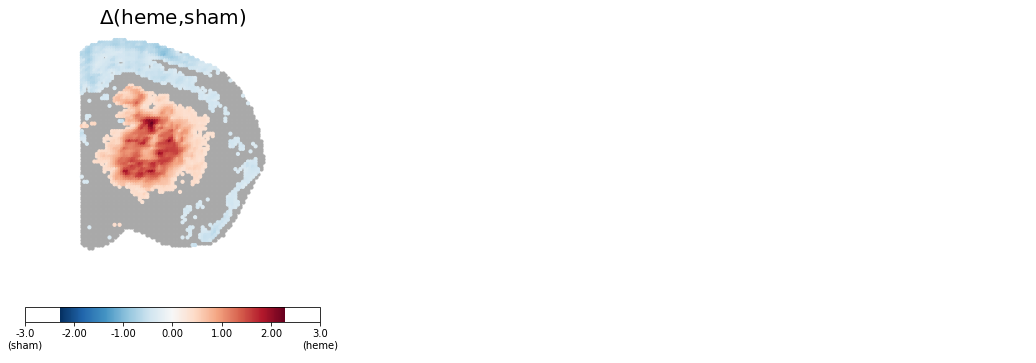

In [164]:
fig,ax = eg.pl.visualize_sdea_results(fa_ref,
                                     res["Cdkn1a"],
                                     n_cols = 3,
                                     marker_size = 10,
                                     side_size = 6,
                                     colorbar_orientation ="horizontal",
                                     title_fontsize = 20,
                                     colorbar_fontsize = 10,
                                     no_sig_color = "darkgray",
                                    )

In [189]:
help(eg.fun.transfer_to_reference)

Help on function transfer_to_reference in module eggplant.methods:

transfer_to_reference(adatas: Union[anndata._core.anndata.AnnData, List[anndata._core.anndata.AnnData], Dict[str, anndata._core.anndata.AnnData]], features: Union[str, List[str]], reference: eggplant.models.Reference, layer: Union[str, NoneType] = None, device: Literal['cpu', 'gpu'] = 'cpu', n_epochs: int = 1000, learning_rate: float = 0.01, subsample: Union[float, int, NoneType] = None, verbose: bool = False, return_models: bool = False, return_losses: bool = True, max_cg_iterations: int = 1000, meta_key: str = 'meta', inference_method: Union[Literal['exact', 'variational'], List[Literal['exact', 'variational']], Dict[str, Literal['exact', 'variational']]] = 'exact', n_inducing_points: int = None, batch_size: Union[int, NoneType] = None, **kwargs) -> Dict[str, Union[List[Union[ForwardRef('m.GPModelExact'), ForwardRef('m.GPModelApprox')]], List[numpy.ndarray]]]
    transfer observed data to a reference
    
    :param 

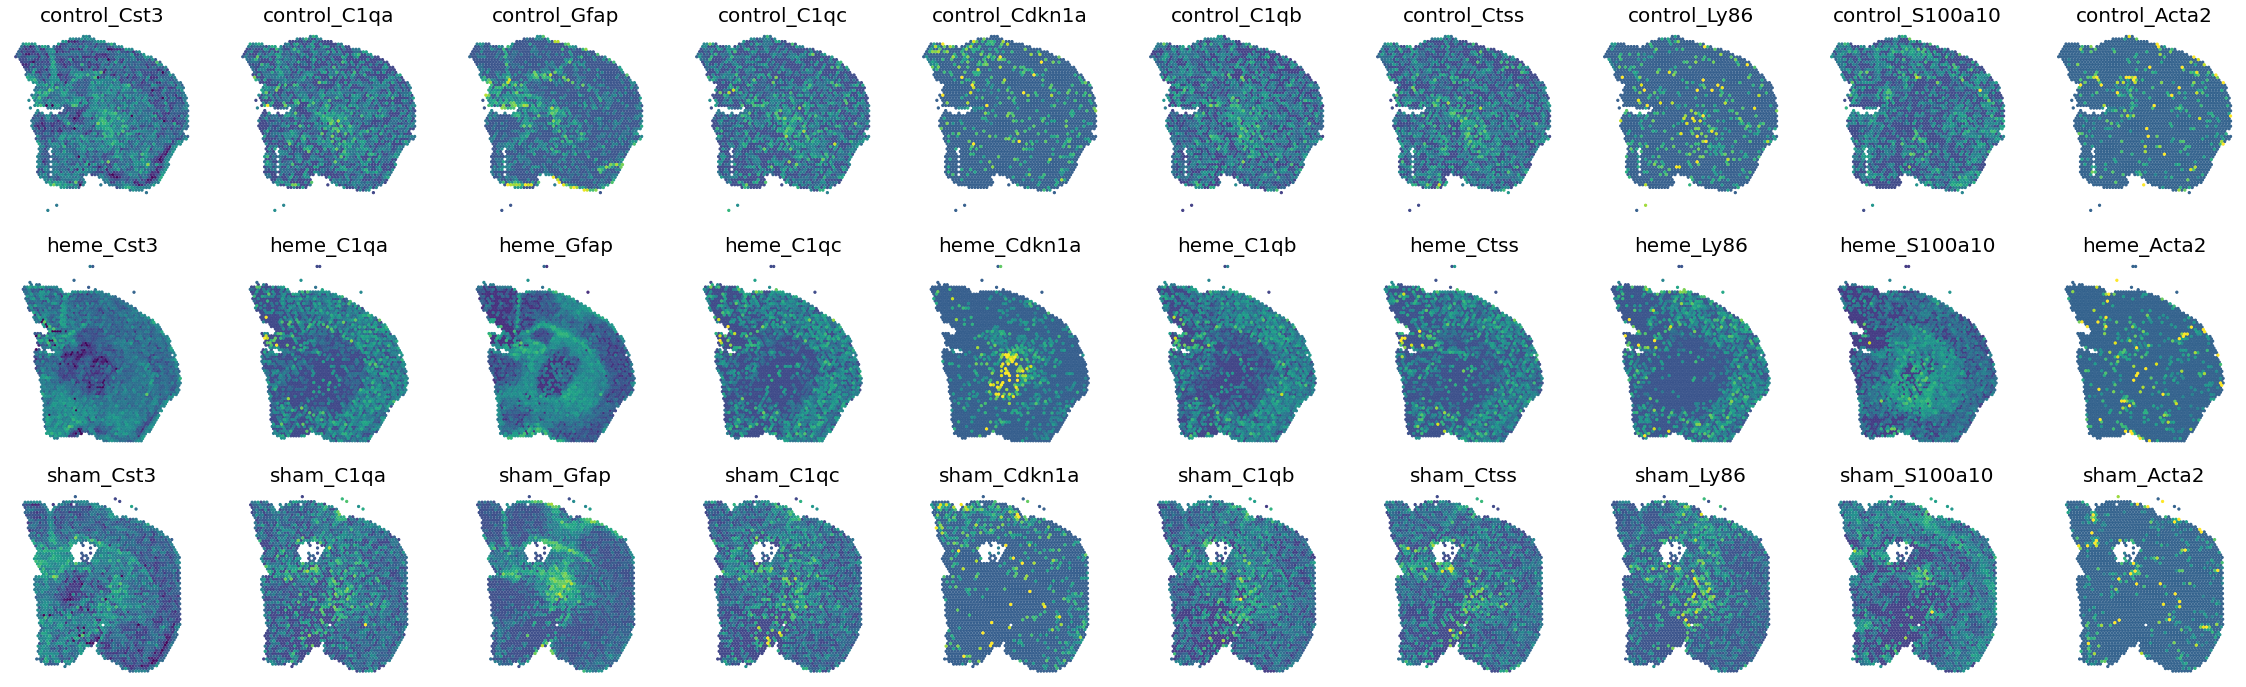

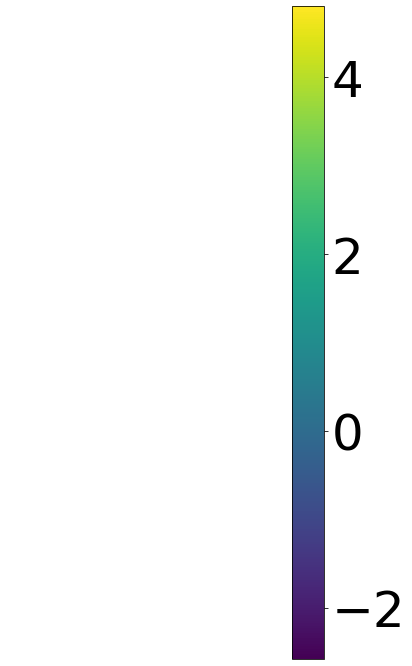

In [173]:
DIFF_GENES = list(z_scores[-10::].index)

eg.pl.visualize_observed(adatas,
                         features = DIFF_GENES,
                         n_rows = 2,
                         include_title = True,
                         fontsize = 20,
                         marker_size =5,
                         share_colorscale = True,
                         separate_colorbar = True,
                         side_size = 4,
                         n_cols = len(DIFF_GENES),
                         show_landmarks = False,
                         quantile_scaling = True,
                         flip_y = True,
                        )